# Connectivity Constraint 

For manufacturability, it is often necessary to impose connectivity constraint during topological optimization, so that all solid pixels are connected to one side (e.g. the supporting substrate). Meep adjoint supports this feature and it is illustrated in this simple tutorial. Please also note that the connectivity constraint is independent from the rest of Meep, and may be used separately.

The basic underlying idea is to solve for an auxilary artificial temperature field. For connected structure, heat can freely flow out, so the temperature in the region should be low overall; on the other hand, for disconnected structure, heat will be trapped in islands, so temperature would be high in some area.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meep.adjoint as mpa

Using MPI version 3.1, 1 processes


/opt/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Given (filtered and projected) design variable `v` with size `(nz, ny, nx)`, `mpa.constraint_connectivity(v, nx, ny, nz)` computes and simultaneously outputs the constraint value (negative for connected structure, positive for disconnected structure) and the gradient of the constraint with respect to `v`. Additional chain rule needs to be applied for gradient with repect to the unprojected and unfiltered design variable.

The temperature field is also returned for reference, but it can be ignored when using the constraint.
#### IMPORTANT: The solver will reshape input `v` via `np.reshape(v, (nz, ny, nx))`. For 2D structure, please specify `ny=1`. The solver assumes the last index of the 0-axis of the array (bottom side of the image above) is where the structure should be connected to. So the user must first rotate the structure properly to match this condition; the gradient must also be post-processed and rotated so that the gradient corresponds correctly.

There are two important hyperparameter, `p` and `cond_s`. The default values should be good in general but it is advised to check and tune them for each individual problem setup so that the constraint behaves as expected.

### disconnected structure

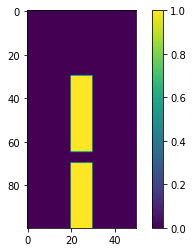

In [2]:
nz, ny, nx = 100, 1, 50
v = np.zeros((nz,ny,nx))
v[30:65,:,20:30]=1
v[70:,:,20:30]=1
plt.imshow(v[:,0,:])
plt.colorbar()

The structure above has one part that is connected to the bottom, but one part is floating above and is disconnected. We can see it has a positive constraint value of around 104

In [3]:
T, f, df_dv = mpa.constraint_connectivity(v, nx, ny, nz, p=6, cond_s=1e6)
f

104.04171048992157

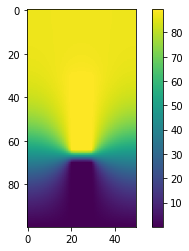

In [4]:
plt.imshow(T.reshape(nz, nx))
plt.colorbar()

The temperature in the region is plotted above. As we can see only the floating part is heated up, while the bottom part is cooled down. We also plotted the gradient below, which has large negative values between the two components, indicating tendency to connect the structure in order to lower the temperature.

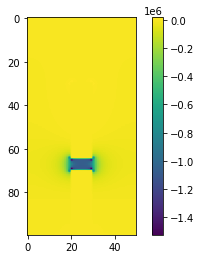

In [5]:
plt.imshow(df_dv.reshape(nz, nx))
plt.colorbar()

### connected structure

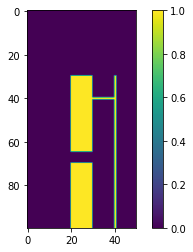

In [6]:

v[30:,:,40]=1
v[40,:,30:40]=1
plt.imshow(v[:,0,:])
plt.colorbar()

In [7]:
T, f, df_dv = mpa.constraint_connectivity(v, nx, ny, nz, p=6, cond_s=1e6)
f

-0.967774527264677

If we connect the structure so that all solid pixel is connected to the bottom, we can see that the constraint value become negative, and the tempeature is low overall as heat is leaked through the bottom side. The gradient values are relatively small in generall as well, indicating no more change is needed to connect the structure.

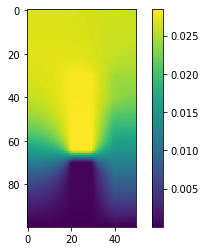

In [8]:
plt.imshow(T.reshape(nz, nx))
plt.colorbar()

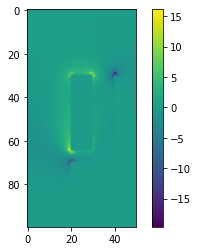

In [9]:
plt.imshow(df_dv.reshape(nz, nx))
plt.colorbar()